In [12]:
using ScikitLearn
using PyPlot, Statistics
using Suppressor: @suppress_err #忽略警告
@suppress_err using Random

@sk_import datasets: (make_circles, make_moons, make_blobs)
@sk_import cluster: (estimate_bandwidth, MeanShift, MiniBatchKMeans, AgglomerativeClustering, SpectralClustering)
@sk_import cluster: (DBSCAN, AffinityPropagation, Birch)
@sk_import preprocessing: StandardScaler
@sk_import neighbors: kneighbors_graph

PyObject <function kneighbors_graph at 0x1a4cb907b8>

In [13]:
Random.seed!(33)

#生成数据集，有噪音
n_samples = 1500
noisy_circles = make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = make_moons(n_samples=n_samples, noise=.05)
blobs = make_blobs(n_samples=n_samples, random_state=8)

colors0 = collect("bgrcmykbgrcmykbgrcmykbgrcmyk")
colors = vcat(fill(colors0, 20)...)

# 聚类名称
clustering_names = [
    "MiniBatchKMeans", "AffinityPropagation", "MeanShift",
    "SpectralClustering",  "Ward", "AgglomerativeClustering",
    "DBSCAN"];

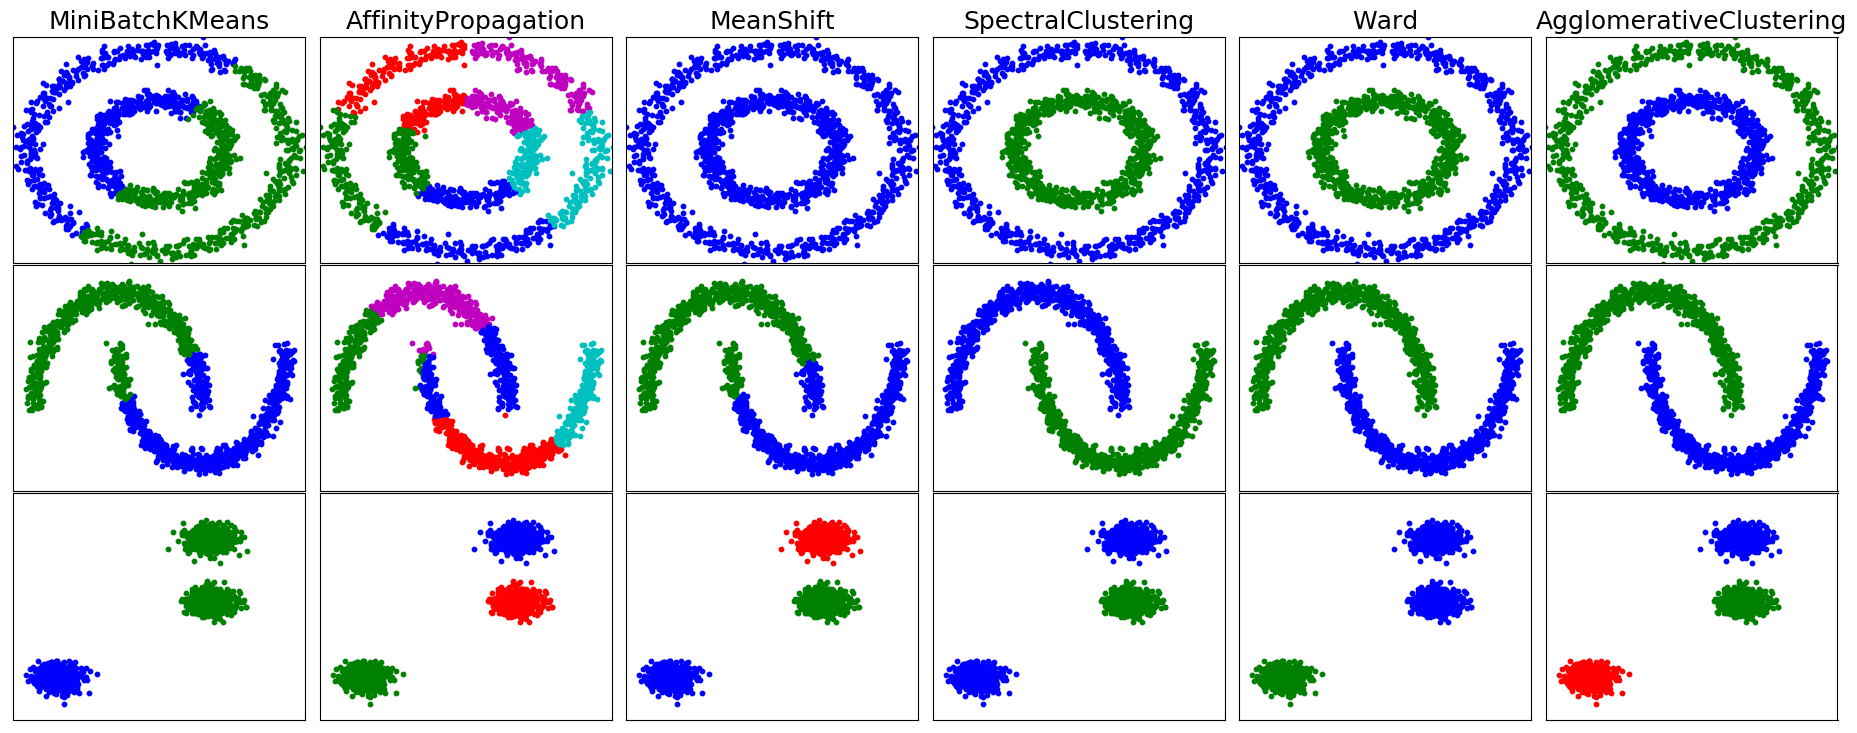

In [17]:
figure(figsize=(length(clustering_names) * 2 + 3, 9.5))
subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

datasets = [noisy_circles, noisy_moons, blobs]

for (i_dataset, dataset) in enumerate(datasets)
    global plot_num
    
    X, y = dataset
    #  标准化数据
    X = fit_transform!(StandardScaler(), X)

    # 估计用于meanshift的bandwidth参数
    bandwidth = estimate_bandwidth(X, quantile=0.3)

    # 生成连接矩阵
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=false)[:todense]()
    connectivity = 0.5 * (connectivity + connectivity')

    # 生成模型
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=true)
    two_means = MiniBatchKMeans(n_clusters=2)
    ward = AgglomerativeClustering(n_clusters=2, linkage="ward",
                                   connectivity=connectivity)
    spectral = SpectralClustering(n_clusters=2,
                                  eigen_solver="arpack",
                                  affinity="nearest_neighbors")
    dbscan = DBSCAN(eps=.2)
    affinity_propagation = AffinityPropagation(damping=.9, preference=-200)

    average_linkage = AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=2,
        connectivity=connectivity)

    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, average_linkage,
        dbscan]

    for (name, algorithm) in zip(clustering_names, clustering_algorithms)
        fit!(algorithm, X)
        y_pred = nothing
        try
            y_pred = predict(algorithm, X)
        catch e
            if isa(e, KeyError)
                y_pred = map(Int, algorithm[:labels_])
                clamp!(y_pred, 0, 27) # not sure why some algorithms return -1
            else rethrow() end
        end
        subplot(4, length(clustering_algorithms), plot_num)
        if i_dataset == 1
            title(name, size=18)
        end

        for y_val in unique(y_pred)
            selected = y_pred.==y_val
            scatter(X[selected, 1], X[selected, 2], color=string(colors0[y_val+1]), s=10)
        end

        xlim(-2, 2)
        ylim(-2, 2)
        xticks(())
        yticks(())
        plot_num += 1
    end
end